# 📊 ANN Regression for PCF-SPR Sensor (Cleaned Version)

This notebook fixes the `NaN` issue and follows the same workflow as the paper’s **Scenario 1**:

1. Load dataset & clean NaNs  
2. Transform outputs (log scale)  
3. Add polynomial features (w², na², etc.)  
4. Normalize inputs  
5. Build and train ANN with safe initialization  
6. Evaluate predictions  

---


In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


In [2]:
# Step 2: Load dataset
data = pd.read_csv("Collected_Data.csv")
data.columns = data.columns.str.strip()

# Drop NaNs
print("NaNs before cleaning:", data.isnull().sum())
data = data.dropna()
print("Shape after dropping NaNs:", data.shape)


NaNs before cleaning: w               0
na              0
neff            0
re(neff)        0
imag(neff)      0
loss            0
SA(1/RIU)     164
rg(um)          0
dtype: int64
Shape after dropping NaNs: (1476, 8)


In [3]:
# Step 3: Transform outputs (log scale)
data['loss_log'] = np.log(data['loss'])
data['SA_log'] = np.log(data['SA(1/RIU)'] + 1000)  # shift to avoid negative/zero

# Step 4: Add polynomial features
data['w^2'] = data['w']**2
data['na^2'] = data['na']**2
data['rg^2'] = data['rg(um)']**2
data['imag^2'] = data['imag(neff)']**2

data['w^3'] = data['w']**3
data['na^3'] = data['na']**3
data['rg^3'] = data['rg(um)']**3
data['imag^3'] = data['imag(neff)']**3

data['w^4'] = data['w']**4
data['na^4'] = data['na']**4
data['rg^4'] = data['rg(um)']**4
data['imag^4'] = data['imag(neff)']**4


In [4]:
# Step 5: Define inputs (X) and outputs (y)
X = data[['w','na','rg(um)','imag(neff)',
          'w^2','na^2','rg^2','imag^2',
          'w^3','na^3','rg^3','imag^3',
          'w^4','na^4','rg^4','imag^4']].values

y = data[['loss_log','SA_log']].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


---
## Step 6: Build ANN
- 4 hidden layers (16 → 50 → 50 → 50)  
- Activation: ReLU  
- Small learning rate (0.00001)  
- Initialization: normal (stddev=0.1)  
- Loss: Mean Squared Logarithmic Error (stable for wide-ranging outputs)  
---


In [5]:
# Step 6: Build ANN
init = initializers.RandomNormal(stddev=0.1)
opt = Adam(learning_rate=0.00001)

model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],), kernel_initializer=init, bias_initializer='zeros'),
    Dense(50, activation='relu', kernel_initializer=init, bias_initializer='zeros'),
    Dense(50, activation='relu', kernel_initializer=init, bias_initializer='zeros'),
    Dense(50, activation='relu', kernel_initializer=init, bias_initializer='zeros'),
    Dense(2, kernel_initializer=init, bias_initializer='zeros')  # 2 outputs
])

model.compile(optimizer=opt, loss='msle', metrics=['mse'])


c:\Users\dskum\Python\deeplearning\langchain\venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Step 7: Train ANN
history = model.fit(X_train, y_train, epochs=200, batch_size=16,
                    validation_split=0.2, verbose=1)


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8552 - mse: 27.0294 - val_loss: 2.8262 - val_mse: 26.9094
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8490 - mse: 27.0143 - val_loss: 2.8202 - val_mse: 26.8950
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8426 - mse: 26.9993 - val_loss: 2.8141 - val_mse: 26.8808
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8360 - mse: 26.9824 - val_loss: 2.8079 - val_mse: 26.8628
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8292 - mse: 26.9622 - val_loss: 2.8012 - val_mse: 26.8434
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8218 - mse: 26.9393 - val_loss: 2.7938 - val_mse: 26.8192
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8138 - mse: 26.9124 - val_loss: 2.7857 - val_mse: 26.7904
Epoch 8/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8046 - mse: 26.8784 - val_loss: 2.7760 - val_mse: 26.7527
Epoch 9/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

Test Loss (MSLE): [0.07769840210676193, 1.500433087348938]
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


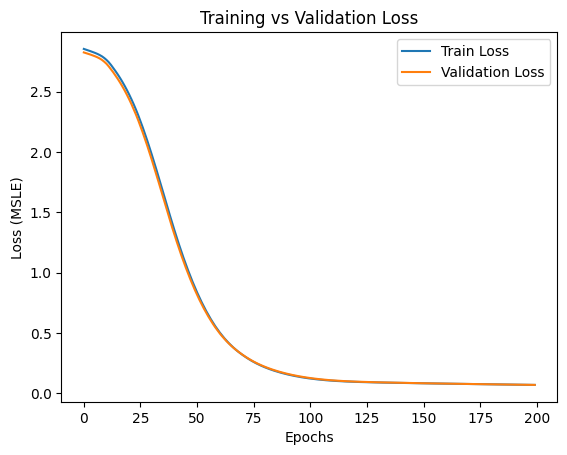

In [7]:
# Step 8: Evaluate and Predict
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss (MSLE):", test_loss)

y_pred = model.predict(X_test)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSLE)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


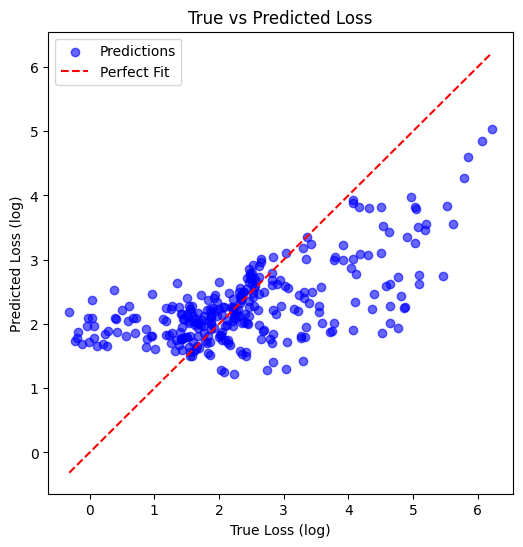

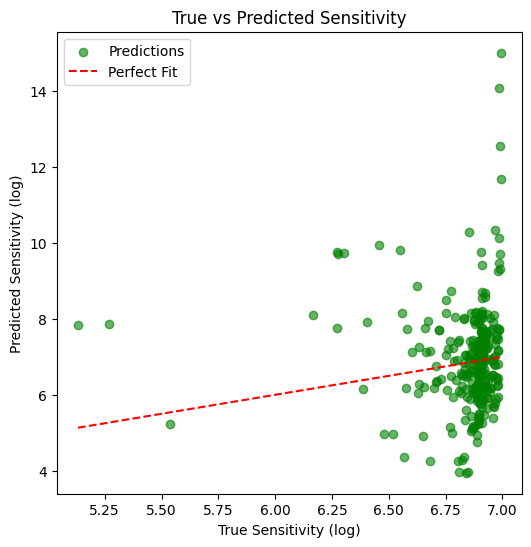

In [8]:
# Step 9: Compare Predictions (scatter plots)

# Loss
plt.figure(figsize=(6,6))
plt.scatter(y_test[:,0], y_pred[:,0], color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test[:,0].min(), y_test[:,0].max()],
         [y_test[:,0].min(), y_test[:,0].max()],
         'r--', label='Perfect Fit')
plt.xlabel("True Loss (log)")
plt.ylabel("Predicted Loss (log)")
plt.title("True vs Predicted Loss")
plt.legend()
plt.show()

# Sensitivity
plt.figure(figsize=(6,6))
plt.scatter(y_test[:,1], y_pred[:,1], color='green', alpha=0.6, label='Predictions')
plt.plot([y_test[:,1].min(), y_test[:,1].max()],
         [y_test[:,1].min(), y_test[:,1].max()],
         'r--', label='Perfect Fit')
plt.xlabel("True Sensitivity (log)")
plt.ylabel("Predicted Sensitivity (log)")
plt.title("True vs Predicted Sensitivity")
plt.legend()
plt.show()


In [1]:
# Create new input
new_data = pd.DataFrame({
    "w": [0.8],
    "na": [1.35],
    "rg(um)": [0.4],
    "imag(neff)": [0.000005]
})

# Add polynomial features (must match training)
new_data["w^2"] = new_data["w"]**2
new_data["na^2"] = new_data["na"]**2
new_data["rg^2"] = new_data["rg(um)"]**2
new_data["imag^2"] = new_data["imag(neff)"]**2

new_data["w^3"] = new_data["w"]**3
new_data["na^3"] = new_data["na"]**3
new_data["rg^3"] = new_data["rg(um)"]**3
new_data["imag^3"] = new_data["imag(neff)"]**3

new_data["w^4"] = new_data["w"]**4
new_data["na^4"] = new_data["na"]**4
new_data["rg^4"] = new_data["rg(um)"]**4
new_data["imag^4"] = new_data["imag(neff)"]**4

# Scale inputs
X_new = scaler.transform(new_data.values)

# Predict
y_new_pred = model.predict(X_new)

# Convert back to real units
loss_new = np.exp(y_new_pred[0][0])
SA_new   = np.exp(y_new_pred[0][1]) - 1000

print(f"Predicted Loss: {loss_new:.4f}")
print(f"Predicted Sensitivity: {SA_new:.4f}")


NameError: name 'pd' is not defined